In [174]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from causememaybe.models import DragonNet
from causememaybe.models.dragon import (DragonLoss, 
                                        TargettedLoss, 
                                        EpsilonLayer)
from causememaybe.models.dragon.data import IhdpDataset

In [41]:
simulation_file_name = "ihdp_npci_4.csv"

In [3]:
ihdp = IhdpDataset(simulation_file_name)
loader = DataLoader(ihdp, batch_size=16)

In [4]:
batch = next(iter(loader))

In [5]:
dragon = DragonNet(
    input_dim=batch[0].shape[1],
    ratio=1)

In [6]:
with torch.no_grad():
    loss = dragon.training_step(batch, None)

In [7]:
trainer = Trainer(gpus=1,
        weights_summary=None,
        checkpoint_callback=False,
        max_epochs=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [8]:
trainer.fit(dragon, train_dataloader=loader)

Epoch 0:  34%|███▍      | 16/47 [00:00<00:00, 83.92it/s, loss=145.737, v_num=0]

/home/jevjev/.pyenv/versions/causememaybe/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 47/47 [00:00<00:00, 77.73it/s, loss=4.035, v_num=0]  


1

In [11]:
train_path = "/home/jevjev/causaldata/ihdp/ihdp_npci_1-1000.train.npz"
test_path = "/home/jevjev/causaldata/ihdp/ihdp_npci_1-1000.test.npz"

In [12]:
train = np.load(train_path, allow_pickle=True)
test = np.load(test_path, allow_pickle=True)

In [24]:
train["yf"][0, 0]

4.77123234193084

In [39]:
train["ycf"][0,0]

-0.298508906888175

In [32]:
train.files

['ate', 'mu1', 'mu0', 'yadd', 'yf', 'ycf', 't', 'x', 'ymul']

In [37]:
train['mu0'][0, 0]

1.16495032360385

In [38]:
train['mu1'][0, 0]

5.8228785047906

# Causal survival bags

In [170]:
def digit_response(digit):
    beta = 365 * np.exp(-0.6*digit) / np.log(1.2)
    event_times = np.random.exponential(beta)
    return event_times

def find_n_largest(unique, counts, n):
    m = sorted(counts, reverse=True)[n]
    return unique[counts.tolist().index(m)]

def survival_function(x, t, eta=0.05):
    y0=1.0
    yT=0.5    
    if t==0:
        y = y0*np.exp(-x**2)
    elif x<0:
        y = yT+(y0-yT)*np.exp(-x**2)
    else:
        y = y0*np.exp(-2*x**2)
    return y+(2*np.random.rand()-1)*eta

### Form a bag

In [179]:
def generate_bag(B):
    labels = np.random.randint(0, 10, size=B)
    unique, counts = np.unique(labels, return_counts=True)

    # generate Gene composition
    first_max_digit = find_n_largest(unique, counts, 0)
    second_max_digit = find_n_largest(unique, counts, 1)
    third_max_digit = find_n_largest(unique, counts, 2)
    gene_expression = first_max_digit - (second_max_digit + third_max_digit) + 3
    return gene_expression

In [180]:
mean_size = 50 
std_size = 10
expressions = []
for _ in range(1000):
    B = int(np.random.normal(loc=mean_size, scale=std_size, size=1))
    expressions.append(generate_bag(B))

(array([  6.,  31.,  29., 132., 108., 234., 223.,  92., 106.,  39.]),
 array([-14. , -11.4,  -8.8,  -6.2,  -3.6,  -1. ,   1.6,   4.2,   6.8,
          9.4,  12. ]),
 <BarContainer object of 10 artists>)

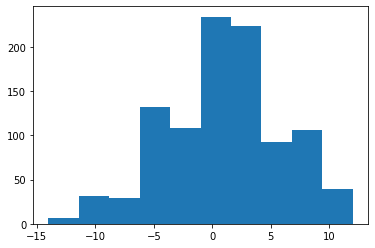

In [181]:
plt.hist(expressions)